## Classification benchmarks: `ZSL`, `Finetuned BERT`, `Unprompted GPT`, `Prompted GPT` and `Finetuned GPT` 

GPT models can also be used for classification tasks. Here I'm putting together a classification benchmark by comparing a ZSL, a finetuned BERT and finetuned / prompted GPT models to see how they perform. I'll try to leverage transfer learning only, meaning I won't be training models (except for GPT SFT)

OpenAI docs: 
- https://platform.openai.com/docs/guides/fine-tuning
- https://platform.openai.com/docs/guides/fine-tuning/advanced-usage
- https://github.com/openai/openai-cookbook/blob/main/examples/Fine-tuned_classification.ipynb

In [58]:
import credentials
import json
import numpy as np
import os
os.environ["OPENAI_API_KEY"] = credentials.openai_api

import openai

from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain import LLMChain
from langchain.prompts import PromptTemplate
from langchain.prompts.few_shot import FewShotPromptTemplate

from transformers import pipeline, AutoTokenizer
from datasets import load_dataset

from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

Load Sentiment dataset from HuggingFace

In [94]:
data = load_dataset('amazon_reviews_multi', 'en', split = 'validation',)

Found cached dataset amazon_reviews_multi (C:/Users/Rabay_Kristof/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


In [95]:
data = pd.DataFrame(data)

data['review'] = data.apply(lambda x: x['review_title'] + '. ' + x['review_body'], axis = 1)

data = data[data['stars'] != 3]
data['sentiment'] = data['stars'].apply(lambda x: 'positive' if x >= 4 else 'negative')

data.drop(labels = ['review_id', 'product_id', 'reviewer_id', 'language', 'review_title', 'review_body', 'stars', 'product_category'], axis = 1, inplace = True)
data = data.sample(frac = 0.125, random_state=43)
data.reset_index(drop = True, inplace = True)

print(data.shape)
data.head(3)

(500, 2)


,review,sentiment
0,"Needed cupcake rings, ended up with breast mil...",negative
1,One Star. This is the band I received.,negative
2,Good washer. Great product especially if you l...,positive


### 1. Zero-Shot-Classifier

Model: `MoritzLaurer/DeBERTa-v3-xsmall-mnli-fever-anli-ling-binary`

In [8]:
model_name = "MoritzLaurer/DeBERTa-v3-xsmall-mnli-fever-anli-ling-binary"
tokenizer = AutoTokenizer.from_pretrained(model_name)

classifier = pipeline("zero-shot-classification", model=model_name, tokenizer=tokenizer, use_fast=False)

In [61]:
candidate_labels = ['positive', 'negative']
sequence_to_classify = data['review'].tolist()

In [24]:
%%time
ZSL_output = classifier(sequence_to_classify, candidate_labels, multi_label=False)

CPU times: total: 6min 15s
Wall time: 1min 38s


In [26]:
ZSL_output[0]

{'sequence': 'Needed cupcake rings, ended up with breast milk steam bags- very unhappy. If I could give this 0 stars I would. It’s not at all what we ordered. Needed these cupcake rings for my daughters birthday party tomorrow and instead I am left with breast pump and breast milk accessory micro steam bags. Wtf.',
 'labels': ['negative', 'positive'],
 'scores': [0.9748134016990662, 0.02518662065267563]}

In [27]:
for i in ZSL_output:
    i['labels'] = i['labels'][0]
    i['scores'] = i['scores'][0]

In [34]:
ZSL_output = pd.DataFrame(ZSL_output)

ZSL_results = data.merge(ZSL_output, left_on = 'review', right_on = 'sequence').drop(labels = ['sequence'], axis = 1)
ZSL_results.head(3)

,review,sentiment,labels,scores
0,"Needed cupcake rings, ended up with breast mil...",negative,negative,0.974813
1,One Star. This is the band I received.,negative,positive,0.885268
2,Good washer. Great product especially if you l...,positive,positive,0.738286


In [37]:
print(classification_report(ZSL_results['sentiment'], ZSL_results['labels']))

              precision    recall  f1-score   support

    negative       0.92      0.87      0.89       253
    positive       0.87      0.92      0.89       247

    accuracy                           0.89       500
   macro avg       0.89      0.89      0.89       500
weighted avg       0.89      0.89      0.89       500



In [50]:
pd.DataFrame(confusion_matrix(ZSL_results['sentiment'], ZSL_results['labels'], labels = ['negative', 'positive']),
             columns = ['Pred - Neg', 'Pred - Pos'], 
             index=['True - Neg', 'True - Pos'])

,Pred - Neg,Pred - Pos
True - Neg,219,34
True - Pos,20,227


### 2. FineTuned BERT

Model: `nlptown/bert-base-multilingual-uncased-sentiment`

In [68]:
pipe = pipeline("text-classification", model = 'nlptown/bert-base-multilingual-uncased-sentiment', use_fast=False)
tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}

In [71]:
%%time
FT_BERT_output = pipe(sequence_to_classify, **tokenizer_kwargs)

CPU times: total: 4min 40s
Wall time: 1min 12s


In [72]:
FT_BERT_output[0]

{'label': '1 star', 'score': 0.9395105838775635}

In [75]:
replacer = {'1 star' : 'negative', 
            '2 stars' : 'negative',
            '3 stars' : 'negative',  
            '4 stars' : 'positive',  
            '5 stars' : 'positive'}
FT_BERT_output = pd.DataFrame(FT_BERT_output).replace(replacer)

FT_BERT_results = pd.concat([data, FT_BERT_output], axis = 1)
FT_BERT_results.head(3)

,review,sentiment,label,score
0,"Needed cupcake rings, ended up with breast mil...",negative,negative,0.939511
1,One Star. This is the band I received.,negative,negative,0.993209
2,Good washer. Great product especially if you l...,positive,positive,0.787920


In [76]:
print(classification_report(FT_BERT_results['sentiment'], FT_BERT_results['label']))

              precision    recall  f1-score   support

    negative       0.91      0.97      0.94       253
    positive       0.97      0.90      0.93       247

    accuracy                           0.94       500
   macro avg       0.94      0.94      0.94       500
weighted avg       0.94      0.94      0.94       500



In [77]:
pd.DataFrame(confusion_matrix(FT_BERT_results['sentiment'], FT_BERT_results['label'], labels = ['negative', 'positive']),
             columns = ['Pred - Neg', 'Pred - Pos'], 
             index=['True - Neg', 'True - Pos'])

,Pred - Neg,Pred - Pos
True - Neg,245,8
True - Pos,24,223


A lot less false positives, a little more FNs (but that may be due to 3 stars mapped to negative, while they should really be neutral)

### 3. Unprompted `GPT` model

Unprompted here refers to 'Zero Shot', meaning no examples are given in the prompt

In [117]:
#llm = OpenAI(model_name="text-davinci-003", temperature = 0, max_tokens = 1, top_p = 1.0)
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature = 0, max_tokens = 1, top_p = 1.0)

template = """Decide whether a product review's sentiment is positive or negative. Only predict positive or negative.
Product review: {review}
Sentiment:"""

prompt = PromptTemplate(input_variables=["review"], template=template)

chain = LLMChain(llm = llm, prompt = prompt)

In [118]:
REVIEW = 'I hated this TV'

print(prompt.format(review = REVIEW))
print(chain.run(REVIEW))

Decide whether a product review's sentiment is positive or negative. Only predict positive or negative.
Product review: I hated this TV
Sentiment:
Negative


In [127]:
%%time
GPT_unprompted_output = [chain.run(i).lower().strip() for i in sequence_to_classify]

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID dcaa5764183f595f6e9d19190922bc5d in your message.).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID ca33f76389e9af6294ef7e870be72bf3 in your message.).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can r

CPU times: total: 2.11 s
Wall time: 10min 59s


In [129]:
GPT_unprompted_results = pd.concat([data, pd.Series(GPT_unprompted_output, name = 'label')], axis = 1)
GPT_unprompted_results.head(3)

,review,sentiment,label
0,"Needed cupcake rings, ended up with breast mil...",negative,negative
1,One Star. This is the band I received.,negative,negative
2,Good washer. Great product especially if you l...,positive,positive


In [131]:
GPT_unprompted_results[~GPT_unprompted_results['label'].isin(['positive', 'negative'])]

,review,sentiment,label
23,Unassembled. The picture shown is of an assemb...,positive,neutral
30,a gift. Bought for my mother in law,positive,neutral
56,Be careful on the print size. It is slightly s...,positive,neutral
77,Works well. The warmer works really well. The ...,positive,mixed
87,Ok. For the price serviceable,positive,neutral
89,Worth reading. Beautifully written. Missing de...,positive,neutral
106,It works.... Well... to lower your pH more qui...,positive,neutral
196,Almost fits. The nylon material feels sturdier...,positive,neutral
227,"Confused. Hi, I lost my AirPod case so I bough...",negative,neutral
255,nice set. Nice set. Set is smaller than I thou...,positive,mixed


In [133]:
GPT_unprompted_results['label'].value_counts()

label
negative    258
positive    226
neutral      13
mixed         3
Name: count, dtype: int64

In [134]:
GPT_unprompted_results = GPT_unprompted_results[GPT_unprompted_results['label'].isin(['positive', 'negative'])]

In [135]:
print(classification_report(GPT_unprompted_results['sentiment'], GPT_unprompted_results['label']))

              precision    recall  f1-score   support

    negative       0.94      0.97      0.96       250
    positive       0.97      0.94      0.95       234

    accuracy                           0.95       484
   macro avg       0.96      0.95      0.95       484
weighted avg       0.95      0.95      0.95       484



In [136]:
pd.DataFrame(confusion_matrix(GPT_unprompted_results['sentiment'], GPT_unprompted_results['label'], labels = ['negative', 'positive']),
             columns = ['Pred - Neg', 'Pred - Pos'], 
             index=['True - Neg', 'True - Pos'])

,Pred - Neg,Pred - Pos
True - Neg,243,7
True - Pos,15,219


Even tho I asked the model to only predict positive or negative, on 13 occasions it predicted neutral, for 3 samples it predicted mixed. This is fine, most items are categorized as expected, and these neutral-mixed elements are correctly labeled as they have been. They really do not seem neither pos nor neg.

Accounting for only the pos-neg items, unprompted GPT is the best model so far, better than a fine tuned BERT...

Let's see if adding few-shots helps the model further

### 4. Prompted `GPT` model

Prompted here refers to 'Few Shot', meaning a couple of examples are given in the prompt

Nice tutorial: https://www.pinecone.io/learn/langchain-prompt-templates/

I'll download another part of the dataset so none of the Few Shots are part of the inference data

In [148]:
fs = load_dataset('amazon_reviews_multi', 'en', split = 'test',)
fs = pd.DataFrame(fs)

fs['review'] = fs.apply(lambda x: x['review_title'] + '. ' + x['review_body'], axis = 1)

fs = fs[fs['stars'] != 3]
fs['sentiment'] = fs['stars'].apply(lambda x: 'positive' if x >= 4 else 'negative')

fs.drop(labels = ['review_id', 'product_id', 'reviewer_id', 'language', 'review_title', 'review_body', 'stars', 'product_category'], axis = 1, inplace = True)
fs = fs.sample(n = 10, random_state=43)
fs.reset_index(drop = True, inplace = True)

few_shots = []

for r, s in zip(fs['review'], fs['sentiment']):
    few_shots.append({'review' : r,
                      'sentiment' : s})

Found cached dataset amazon_reviews_multi (C:/Users/Rabay_Kristof/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


In [149]:
few_shots[:3]

[{'review': 'Don’t waste your time. Made very cheap!!!! you get what you pay for',
  'sentiment': 'negative'},
 {'review': 'Does not lay flat. Creased beyond usefulness.. I SHOULD HAVE RETURNED THIS PRODUCT BUT THE RETURN WINDOW RAN OUT. The liner comes folded and does not lay flat. I thought that if I left it out, the material would eventually relax and become flat. It has been out a week and it I still all rippled. Why would the manufacturer not ship it in a tube or wrapped around a tube!!!! This liner is useless. What a joke. Do not buy.',
  'sentiment': 'negative'},
 {'review': 'Works as intended on 2006 Honda Accord sedan. 2006 Honda Accord sedan. Had a difficult time trying to install unit. Fully assembled, the unit was not fitting into the small space. The arms were hitting and I could not get it to go in. Not sure if this is the way to go, but I disconnected the rod from the motor gear so I could "flatten" out the linkage. Once I did this the unit slid into place very easily. T

Put together Few-Shot prompt

In [150]:
prefix = """Given the following few examples, decide whether a product review's sentiment is positive or negative. Only predict positive or negative."""

example_prompt = """
Product review: {review}
Sentiment: {sentiment}"""

suffix = """
Product review: {review}
Sentiment:"""

example_prompt = PromptTemplate(
    input_variables=["review", "sentiment"],
    template=example_prompt
)

few_shot_prompt_template = FewShotPromptTemplate(
    examples=few_shots,
    example_prompt=example_prompt,
    prefix=prefix,
    suffix=suffix,
    input_variables=["review"],
    example_separator="\n"
)

In [152]:
REVIEW = 'I hated this TV'
print(few_shot_prompt_template.format(review = REVIEW))

Given the following few examples, decide whether a product review's sentiment is positive or negative. Only predict positive or negative.

Product review: Don’t waste your time. Made very cheap!!!! you get what you pay for
Sentiment: negative

Product review: Does not lay flat. Creased beyond usefulness.. I SHOULD HAVE RETURNED THIS PRODUCT BUT THE RETURN WINDOW RAN OUT. The liner comes folded and does not lay flat. I thought that if I left it out, the material would eventually relax and become flat. It has been out a week and it I still all rippled. Why would the manufacturer not ship it in a tube or wrapped around a tube!!!! This liner is useless. What a joke. Do not buy.
Sentiment: negative

Product review: Works as intended on 2006 Honda Accord sedan. 2006 Honda Accord sedan. Had a difficult time trying to install unit. Fully assembled, the unit was not fitting into the small space. The arms were hitting and I could not get it to go in. Not sure if this is the way to go, but I disc

In [153]:
print(chain.run(REVIEW))

Negative


In [156]:
%%time
GPT_prompted_output = [chain.run(i).lower().strip() for i in sequence_to_classify]

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 8c854e046857c92a2e71c5c5ab64ec49 in your message.).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 4e6ed3ab0def2676ae502db678a2108b in your message.).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can r

CPU times: total: 1.77 s
Wall time: 12min 21s


In [157]:
GPT_prompted_results = pd.concat([data, pd.Series(GPT_prompted_output, name = 'label')], axis = 1)
GPT_prompted_results.head(3)

,review,sentiment,label
0,"Needed cupcake rings, ended up with breast mil...",negative,negative
1,One Star. This is the band I received.,negative,negative
2,Good washer. Great product especially if you l...,positive,positive


In [159]:
GPT_prompted_results[~GPT_prompted_results['label'].isin(['positive', 'negative'])]

,review,sentiment,label
23,Unassembled. The picture shown is of an assemb...,positive,neutral
30,a gift. Bought for my mother in law,positive,neutral
56,Be careful on the print size. It is slightly s...,positive,neutral
77,Works well. The warmer works really well. The ...,positive,mixed
87,Ok. For the price serviceable,positive,neutral
89,Worth reading. Beautifully written. Missing de...,positive,neutral
106,It works.... Well... to lower your pH more qui...,positive,neutral
196,Almost fits. The nylon material feels sturdier...,positive,neutral
227,"Confused. Hi, I lost my AirPod case so I bough...",negative,neutral
357,Need more info. It would be nice to know what ...,negative,neutral


In [158]:
GPT_prompted_results['label'].value_counts()

label
negative    259
positive    226
neutral      13
mixed         2
Name: count, dtype: int64

In [160]:
GPT_prompted_results = GPT_prompted_results[GPT_prompted_results['label'].isin(['positive', 'negative'])]

In [161]:
print(classification_report(GPT_prompted_results['sentiment'], GPT_prompted_results['label']))

              precision    recall  f1-score   support

    negative       0.94      0.97      0.95       250
    positive       0.97      0.93      0.95       235

    accuracy                           0.95       485
   macro avg       0.95      0.95      0.95       485
weighted avg       0.95      0.95      0.95       485



In [162]:
pd.DataFrame(confusion_matrix(GPT_prompted_results['sentiment'], GPT_prompted_results['label'], labels = ['negative', 'positive']),
             columns = ['Pred - Neg', 'Pred - Pos'], 
             index=['True - Neg', 'True - Pos'])

,Pred - Neg,Pred - Pos
True - Neg,243,7
True - Pos,16,219


Same performance as unprompted model. Seems like scoring the sentiment of product reviews is pretty easy for ChatGPT. For numerical scoring, like 1-5, or -1 to +1, few shot prompting would definitely help

### 5.1 Finetuning `GPT-ada` model for product review sentiment scoring

Here I'm actually going to fine tune a GPT-3 model whose only job will be to decide product review's sentiment (positive or negative). This avoids long prompts, but finetuned models are more expensive for inference. This is experimental, GPT models should not be used for such basic tasks. Even tho they seem to outperform BERT models finetuned for exactly the same downstream tasks :D 

First, I'll finetune the smallest, fastest, least accurate `ada` model. Then I'll jump to `davinci`

Again, I'll be finetuning and inferencing on different datasets

In [11]:
ft = load_dataset('amazon_reviews_multi', 'en', split = 'test',)
ft = pd.DataFrame(ft)

ft['review'] = ft.apply(lambda x: x['review_title'] + '. ' + x['review_body'], axis = 1)

ft = ft[ft['stars'] != 3]
ft['sentiment'] = ft['stars'].apply(lambda x: 'positive' if x >= 4 else 'negative')

ft.drop(labels = ['review_id', 'product_id', 'reviewer_id', 'language', 'review_title', 'review_body', 'stars', 'product_category'], axis = 1, inplace = True)
ft = ft.sample(n = 500, random_state=43)
ft.reset_index(drop = True, inplace = True)

ft.columns = ['prompt', 'completion']

print(ft.shape)
ft.head(3)

Found cached dataset amazon_reviews_multi (C:/Users/Rabay_Kristof/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


(500, 2)


,prompt,completion
0,Don’t waste your time. Made very cheap!!!! you...,negative
1,Does not lay flat. Creased beyond usefulness.....,negative
2,Works as intended on 2006 Honda Accord sedan. ...,positive


Save as `JSONL`

In [12]:
ft.to_json("../docs/classification/all_training_data.jsonl", orient='records', lines=True)

Prepare training data with `openAI` CLI

In [13]:
!openai tools fine_tunes.prepare_data -f ../docs/classification/all_training_data.jsonl -q

Analyzing...

- Your file contains 500 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts empty
- The completion should start with a whitespace character (` `). This tends to produce better results due to the tokenization we use. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for 

There are 400 samples in the corrected train JSONL, and 100 in the valid, so OpenAI uses an 80-20% split ratio automatically

Start fine-tuning job

- will use `ada` model
- will train for 3 epochs
- will ask OpenAI to calculate classification metrics

In [14]:
!openai api fine_tunes.create \
--training_file ../docs/classification/all_training_data_prepared_train.jsonl \
--validation_file ../docs/classification/all_training_data_prepared_valid.jsonl \
--model ada \
--suffix "SentimentScorer" \
--n_epochs 3 \
--compute_classification_metrics \
--classification_positive_class " positive"

Uploaded file from ../docs/classification/all_training_data_prepared_train.jsonl: file-cPbbANAArMg2DIxvrgjIu9RR
Uploaded file from ../docs/classification/all_training_data_prepared_valid.jsonl: file-JYqiVJw13D2TmKzjKKFo1Xqc
Created fine-tune: ft-v8f3alMpQEH6F3QVaxtyyn7M
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-05-10 22:56:44] Created fine-tune: ft-v8f3alMpQEH6F3QVaxtyyn7M
[2023-05-10 22:56:58] Fine-tune costs $0.02
[2023-05-10 22:56:58] Fine-tune enqueued. Queue number: 1




Upload progress:   0%|          | 0.00/93.3k [00:00<?, ?it/s]
Upload progress: 100%|██████████| 93.3k/93.3k [00:00<00:00, 90.0Mit/s]

Upload progress:   0%|          | 0.00/23.7k [00:00<?, ?it/s]
Upload progress: 100%|██████████| 23.7k/23.7k [00:00<00:00, 23.6Mit/s]


In [21]:
!openai api fine_tunes.follow -i ft-v8f3alMpQEH6F3QVaxtyyn7M

[2023-05-10 22:56:44] Created fine-tune: ft-v8f3alMpQEH6F3QVaxtyyn7M
[2023-05-10 22:56:58] Fine-tune costs $0.02
[2023-05-10 22:56:58] Fine-tune enqueued. Queue number: 1
[2023-05-10 23:05:02] Fine-tune is in the queue. Queue number: 0
[2023-05-10 23:07:34] Fine-tune started
[2023-05-10 23:08:51] Completed epoch 1/3
[2023-05-10 23:09:56] Completed epoch 2/3
[2023-05-10 23:10:59] Completed epoch 3/3
[2023-05-10 23:11:18] Uploaded model: ada:ft-hiflylabs-zrt:sentimentscorer-2023-05-10-21-11-18
[2023-05-10 23:11:20] Uploaded result file: file-2PyDPgGiMNZwSls2BOY5Yrte
[2023-05-10 23:11:20] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m ada:ft-hiflylabs-zrt:sentimentscorer-2023-05-10-21-11-18 -p <YOUR_PROMPT>


Download eval results

In [22]:
!openai api fine_tunes.results -i ft-v8f3alMpQEH6F3QVaxtyyn7M > ../docs/classification/results.csv

In [24]:
gpt_ft_results = pd.read_csv('../docs/classification/results.csv')
gpt_ft_results.tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/precision,classification/recall,classification/auroc,classification/auprc,classification/f1.0
1200,1201,58713,1201,0.031296,1.0,1.0,0.046186,1.0,1.0,0.96,0.979592,0.941176,0.988796,0.990172,0.96


<Axes: >

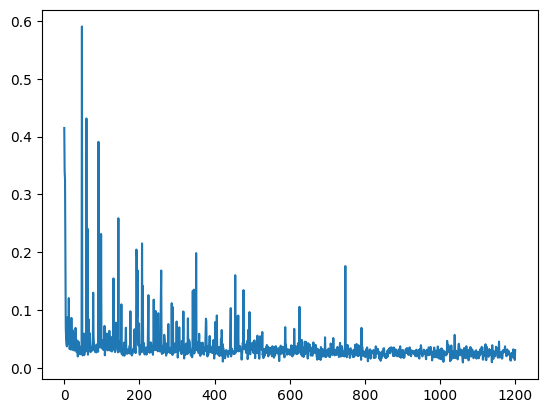

In [29]:
gpt_ft_results[['step', 'training_loss', 'classification/accuracy']]['training_loss'].plot()

<Axes: >

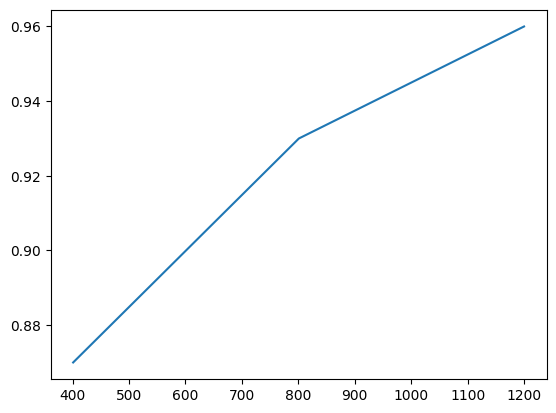

In [32]:
gpt_ft_results[gpt_ft_results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

Try out model

In [37]:
!openai api completions.create \
    -m ada:ft-hiflylabs-zrt:sentimentscorer-2023-05-10-21-11-18 \
    -p "I kind of liked it at the beginning but then realized this is not what I expected. ->" \
    --max-tokens 1 \
    --temperature 0.0

I kind of liked it at the beginning but then realized this is not what I expected. -> negative


Run on original 500-batch to compare against all previous models

In [107]:
ft_model = 'ada:ft-hiflylabs-zrt:sentimentscorer-2023-05-10-21-11-18'

def GPT_completion(prompt, model):
    res = openai.Completion.create(model=ft_model, prompt=prompt + ' ->', max_tokens=1, temperature=0, logprobs=2)
    output = res['choices'][0]
    return output['text'].strip().lower(), np.exp(output['logprobs']['token_logprobs'][0])

In [64]:
%%time
GPT_ft_output = [GPT_completion(i) for i in sequence_to_classify]

CPU times: total: 1.55 s
Wall time: 1min 49s


In [68]:
GPT_ft_output = pd.DataFrame(GPT_ft_output, columns = ['label', 'score'])

In [70]:
GPT_ft_results = pd.concat([data, GPT_ft_output], axis = 1)
GPT_ft_results.head(3)

,review,sentiment,label,score
0,"Needed cupcake rings, ended up with breast mil...",negative,negative,0.999172
1,One Star. This is the band I received.,negative,negative,0.999494
2,Good washer. Great product especially if you l...,positive,positive,0.999855


In [73]:
GPT_ft_results['label'].value_counts()

label
positive    257
negative    243
Name: count, dtype: int64

Finally, only pos and neg labels, as we wanted

In [76]:
print(classification_report(GPT_ft_results['sentiment'], GPT_ft_results['label']))

              precision    recall  f1-score   support

    negative       0.94      0.90      0.92       253
    positive       0.90      0.94      0.92       247

    accuracy                           0.92       500
   macro avg       0.92      0.92      0.92       500
weighted avg       0.92      0.92      0.92       500



In [77]:
pd.DataFrame(confusion_matrix(GPT_ft_results['sentiment'], GPT_ft_results['label'], labels = ['negative', 'positive']),
             columns = ['Pred - Neg', 'Pred - Pos'], 
             index=['True - Neg', 'True - Pos'])

,Pred - Neg,Pred - Pos
True - Neg,228,25
True - Pos,15,232


Check mistakes out of curiosity

In [85]:
GPT_ft_results[GPT_ft_results['sentiment'] != GPT_ft_results['label']].sample(4, random_state = 7)

,review,sentiment,label,score
250,Brittle stems of Knight Visors.. Did not like ...,positive,negative,0.999668
448,Usage Info. Product arrived with no documentat...,negative,positive,0.742399
403,"Solid Bluetooth Connection to Apple Watch, med...",positive,negative,0.520883
258,Simply does not work as described. Literally j...,negative,positive,0.521634


### 5.2 Finetuning `GPT-davinci` model

We've seen how `ada` performed, and it was already very good. Now let's see how far can `davinci` go. `--no_check_if_files_exist` is set because training and validation files have already been uploaded once

In [99]:
!openai api fine_tunes.create \
--training_file ../docs/classification/all_training_data_prepared_train.jsonl \
--validation_file ../docs/classification/all_training_data_prepared_valid.jsonl \
--no_check_if_files_exist \
--model davinci \
--suffix "SentimentScorer" \
--n_epochs 3 \
--compute_classification_metrics \
--classification_positive_class " positive"

Uploaded file from ../docs/classification/all_training_data_prepared_train.jsonl: file-cFv0IggyEL8PlaUNLD0Kqzzh
Uploaded file from ../docs/classification/all_training_data_prepared_valid.jsonl: file-9ZQwaFP5ZnDcvxY6RzFyDn5f
Created fine-tune: ft-FiBliM5WUvStWnNWsYScIdsy
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-05-11 12:55:36] Created fine-tune: ft-FiBliM5WUvStWnNWsYScIdsy

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-FiBliM5WUvStWnNWsYScIdsy




Upload progress:   0%|          | 0.00/93.3k [00:00<?, ?it/s]
Upload progress: 100%|██████████| 93.3k/93.3k [00:00<00:00, 23.4Mit/s]

Upload progress:   0%|          | 0.00/23.7k [00:00<?, ?it/s]
Upload progress: 100%|██████████| 23.7k/23.7k [00:00<00:00, 23.6Mit/s]


In [101]:
!openai api fine_tunes.follow -i ft-FiBliM5WUvStWnNWsYScIdsy

[2023-05-11 12:55:36] Created fine-tune: ft-FiBliM5WUvStWnNWsYScIdsy
[2023-05-11 12:56:54] Fine-tune costs $1.63
[2023-05-11 12:56:54] Fine-tune enqueued. Queue number: 7
[2023-05-11 12:57:41] Fine-tune is in the queue. Queue number: 6
[2023-05-11 12:58:27] Fine-tune is in the queue. Queue number: 5
[2023-05-11 12:58:42] Fine-tune is in the queue. Queue number: 4
[2023-05-11 12:59:57] Fine-tune is in the queue. Queue number: 3
[2023-05-11 13:01:00] Fine-tune is in the queue. Queue number: 2
[2023-05-11 13:01:05] Fine-tune is in the queue. Queue number: 1
[2023-05-11 13:03:43] Fine-tune is in the queue. Queue number: 0
[2023-05-11 13:03:58] Fine-tune started
[2023-05-11 13:07:49] Completed epoch 1/3
[2023-05-11 13:10:02] Completed epoch 2/3
[2023-05-11 13:12:12] Completed epoch 3/3
[2023-05-11 13:13:11] Uploaded model: davinci:ft-hiflylabs-zrt:sentimentscorer-2023-05-11-11-13-11
[2023-05-11 13:13:13] Uploaded result file: file-pj0PihFbiga2ucQPWYIvY5ya
[2023-05-11 13:13:13] Fine-tune suc

In [102]:
!openai api fine_tunes.results -i ft-FiBliM5WUvStWnNWsYScIdsy > ../docs/classification/results_davinci.csv

In [103]:
gpt_ft_davinci_results = pd.read_csv('../docs/classification/results_davinci.csv')
gpt_ft_davinci_results.tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/precision,classification/recall,classification/auroc,classification/auprc,classification/f1.0
1200,1201,58649,1201,0.03445,1.0,1.0,0.017706,1.0,1.0,0.98,0.980392,0.980392,0.9996,0.999619,0.980392


<Axes: >

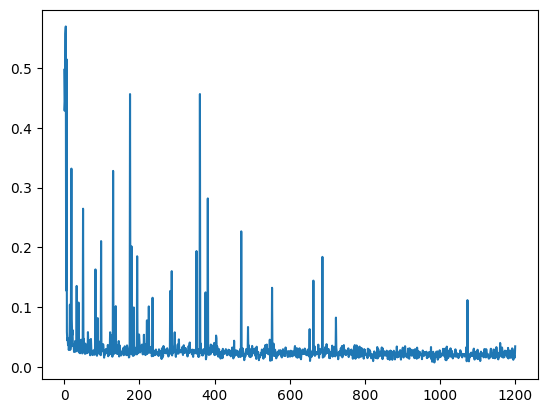

In [104]:
gpt_ft_davinci_results[['step', 'training_loss', 'classification/accuracy']]['training_loss'].plot()

<Axes: >

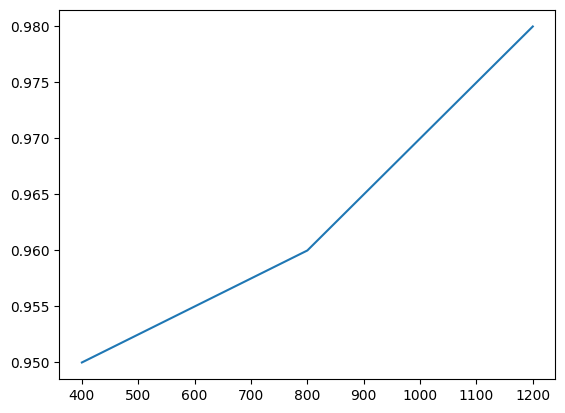

In [105]:
gpt_ft_davinci_results[gpt_ft_davinci_results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

Try `davinci` model

In [106]:
!openai api completions.create \
    -m davinci:ft-hiflylabs-zrt:sentimentscorer-2023-05-11-11-13-11 \
    -p "I kind of liked it at the beginning but then realized this is not what I expected. ->" \
    --max-tokens 1 \
    --temperature 0.0

I kind of liked it at the beginning but then realized this is not what I expected. -> negative


Batch run

In [108]:
ft_davinci_model = 'davinci:ft-hiflylabs-zrt:sentimentscorer-2023-05-11-11-13-11'

In [110]:
test_text = "It's a little too busy for me. Too many straps but is exactly what the picture shows."
GPT_completion(test_text, ft_davinci_model) 

('positive', 0.9996239431571067)

In [111]:
%%time
GPT_ft_davinci_output = [GPT_completion(i, ft_davinci_model) for i in sequence_to_classify]

CPU times: total: 1.48 s
Wall time: 1min 34s


In [113]:
GPT_ft_davinci_output = pd.DataFrame(GPT_ft_davinci_output, columns = ['label', 'score'])

In [114]:
GPT_ft_davinci_results = pd.concat([data, GPT_ft_davinci_output], axis = 1)
GPT_ft_davinci_results.head(3)

,review,sentiment,label,score
0,"Needed cupcake rings, ended up with breast mil...",negative,negative,0.999172
1,One Star. This is the band I received.,negative,negative,0.999494
2,Good washer. Great product especially if you l...,positive,positive,0.999855


In [116]:
print(classification_report(GPT_ft_davinci_results['sentiment'], GPT_ft_davinci_results['label']))

              precision    recall  f1-score   support

    negative       0.94      0.90      0.92       253
    positive       0.90      0.94      0.92       247

    accuracy                           0.92       500
   macro avg       0.92      0.92      0.92       500
weighted avg       0.92      0.92      0.92       500



In [117]:
pd.DataFrame(confusion_matrix(GPT_ft_davinci_results['sentiment'], GPT_ft_davinci_results['label'], labels = ['negative', 'positive']),
             columns = ['Pred - Neg', 'Pred - Pos'], 
             index=['True - Neg', 'True - Pos'])

,Pred - Neg,Pred - Pos
True - Neg,228,25
True - Pos,15,232


In [119]:
pd.set_option('display.max_colwidth', None)

In [122]:
GPT_ft_davinci_results[GPT_ft_davinci_results['sentiment'] != GPT_ft_davinci_results['label']].sample(4, random_state = 3)

,review,sentiment,label,score
379,Bought 3 but only 2 work. I bought 3 total and when I got the 3rd one opened and started to use it it does not suction to the surfaces. Can I return it? I have since washed it and do not have the box anymore.,positive,negative,0.998850
238,xd beast case. got super dirty which was gross but my phone never broke in it so maybe get a different color than white lmao,negative,positive,0.954806
167,hard hard hard. this candy is very hard hard hard never again,negative,positive,0.511402
366,It's okay. I thought it would be bigger in the inside but overall it does the trick.,negative,positive,0.996221
